In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import random

# Setting seeds for reproducibility.
SEED = 42
keras.utils.set_random_seed(SEED)

2025-11-02 08:50:19.650348: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 100

# AUGMENTATION
IMAGE_SIZE = 48  # We will resize input images to this size.
PATCH_SIZE = 6  # Size of the patches to be extracted from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75  # We have found 75% masking to give us the best results.

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices(x_test)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Training samples: 40000
Validation samples: 10000
Testing samples: 10000


I0000 00:00:1762069861.038542   10707 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9033 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [4]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        ],
        name="test_data_augmentation",
    )
    return model

In [5]:
class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

        # Assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3).
        self.resize = layers.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        # Create patches from the input images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch):
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

Index selected: 102.


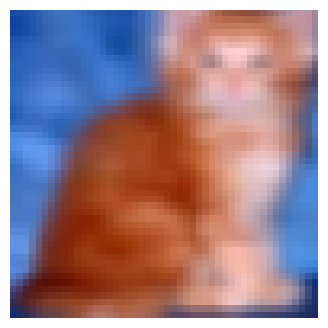

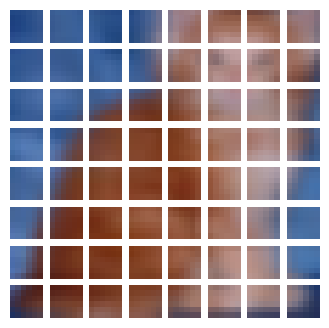

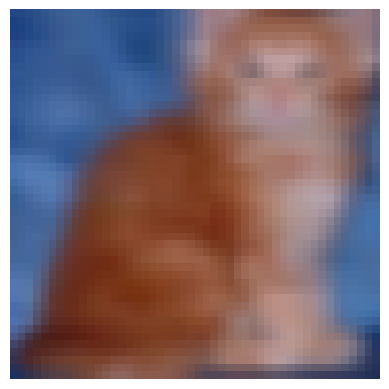

In [6]:
# Get a batch of images.
image_batch = next(iter(train_ds))

# Augment the images.
augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)

# Define the patch layer.
patch_layer = Patches()

# Get the patches from the batched images.
patches = patch_layer(images=augmented_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()

In [7]:
class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

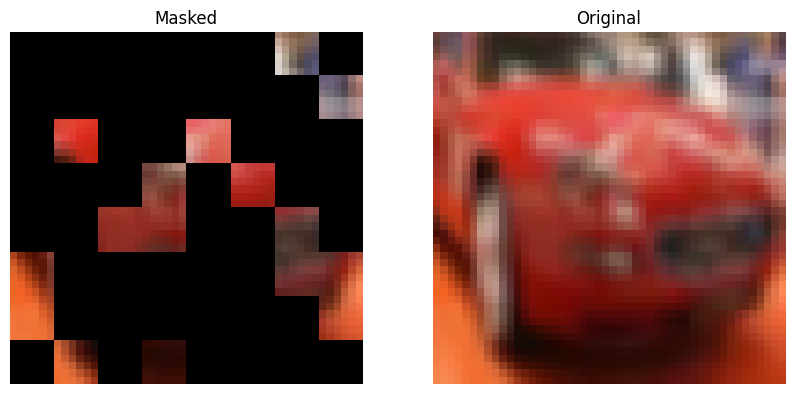

In [8]:
# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)


# Show a maksed patch image.
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()

In [9]:
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

In [11]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")

In [12]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compute_loss(y=loss_patch, y_pred=loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for grad, var in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        results = {}
        for metric in self.metrics:
            metric.update_state(loss_patch, loss_output)
            results[metric.name] = metric.result()
        return results

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)

        # Update the trackers.
        results = {}
        for metric in self.metrics:
            metric.update_state(loss_patch, loss_output)
            results[metric.name] = metric.result()
        return results

In [13]:
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

In [14]:
# Taking a batch of test inputs to measure model's progress.
test_images = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

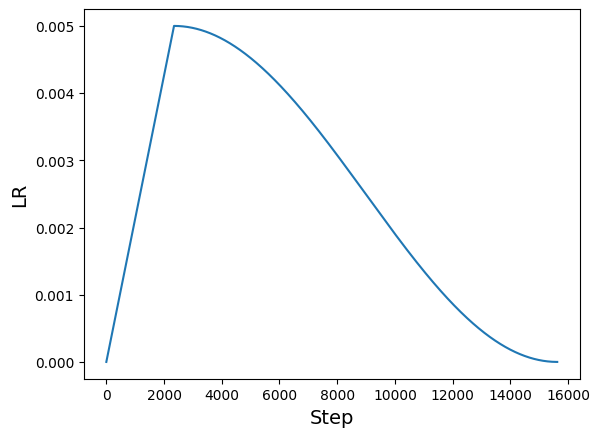

In [15]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.


class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]

Epoch 1/100
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - mae: 0.2035 - loss: 0.4826
Idx chosen: 92


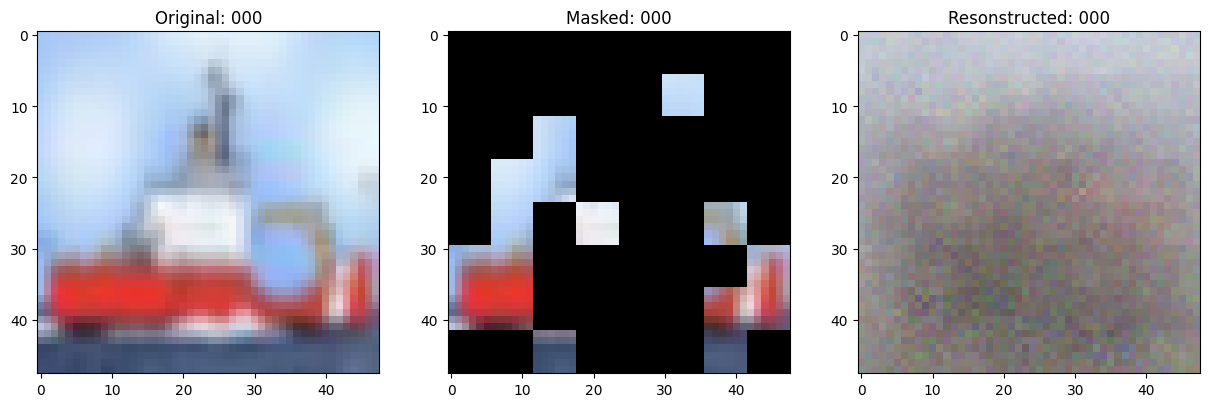

157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - mae: 0.1650 - loss: 0.4944 - val_loss: 0.5207
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - mae: 0.1472 - loss: 0.5153 - val_loss: 0.5227
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - mae: 0.1404 - loss: 0.5261 - val_loss: 0.5316
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - mae: 0.1357 - loss: 0.5318 - val_loss: 0.5346
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - mae: 0.1211 - loss: 0.5373 - val_loss: 0.5446
Epoch 6/100
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - mae: 0.1223 - loss: 0.5410
Idx chosen: 14


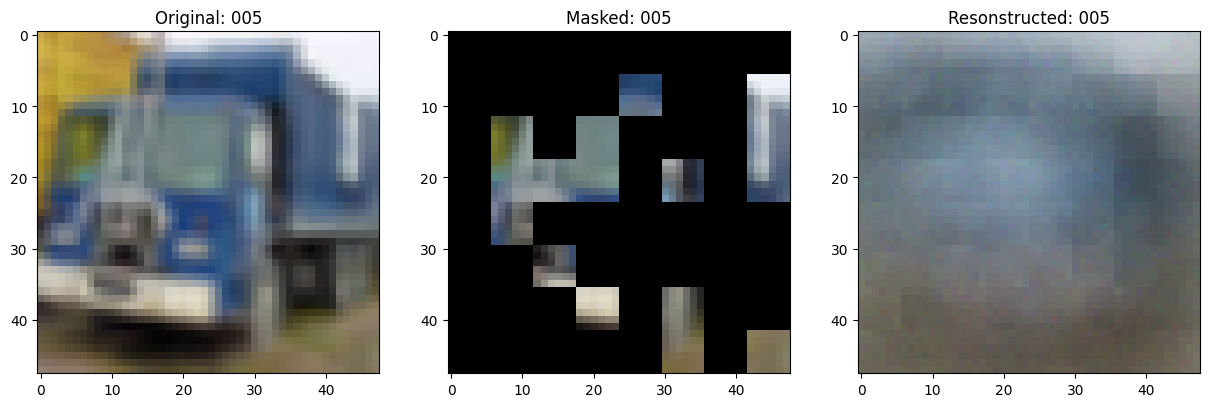

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - mae: 0.1166 - loss: 0.5419 - val_loss: 0.5538
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - mae: 0.1164 - loss: 0.5455 - val_loss: 0.5452
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - mae: 0.1104 - loss: 0.5479 - val_loss: 0.5573
Epoch 9/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - mae: 0.1070 - loss: 0.5498 - val_loss: 0.5566
Epoch 10/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - mae: 0.1051 - loss: 0.5514 - val_loss: 0.5566
Epoch 11/100
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - mae: 0.1059 - loss: 0.5522
Idx chosen: 106


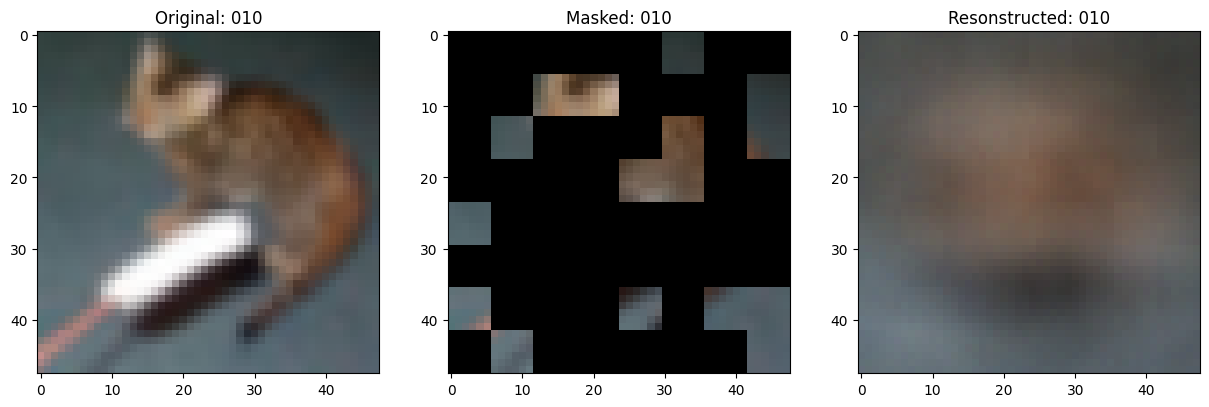

157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - mae: 0.1054 - loss: 0.5523 - val_loss: 0.5585
Epoch 12/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - mae: 0.1024 - loss: 0.5529 - val_loss: 0.5590
Epoch 13/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - mae: 0.1117 - loss: 0.5537 - val_loss: 0.5545
Epoch 14/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - mae: 0.1012 - loss: 0.5541 - val_loss: 0.5585
Epoch 15/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - mae: 0.0999 - loss: 0.5545 - val_loss: 0.5624
Epoch 16/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - mae: 0.1007 - loss: 0.5555
Idx chosen: 71


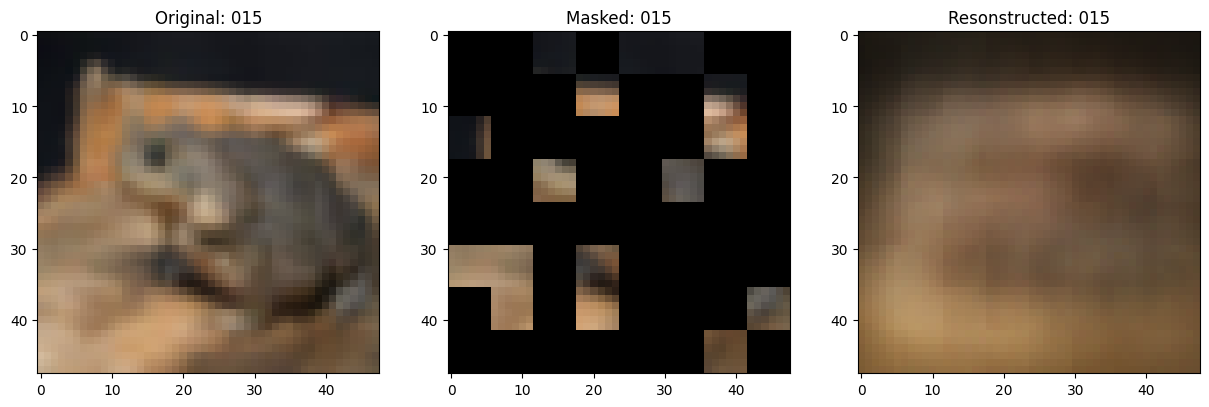

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - mae: 0.1043 - loss: 0.5553 - val_loss: 0.5615
Epoch 17/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - mae: 0.0997 - loss: 0.5557 - val_loss: 0.5609
Epoch 18/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - mae: 0.0976 - loss: 0.5564 - val_loss: 0.5607
Epoch 19/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - mae: 0.0978 - loss: 0.5564 - val_loss: 0.5642
Epoch 20/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - mae: 0.0982 - loss: 0.5569 - val_loss: 0.5645
Epoch 21/100
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - mae: 0.0977 - loss: 0.5568
Idx chosen: 188


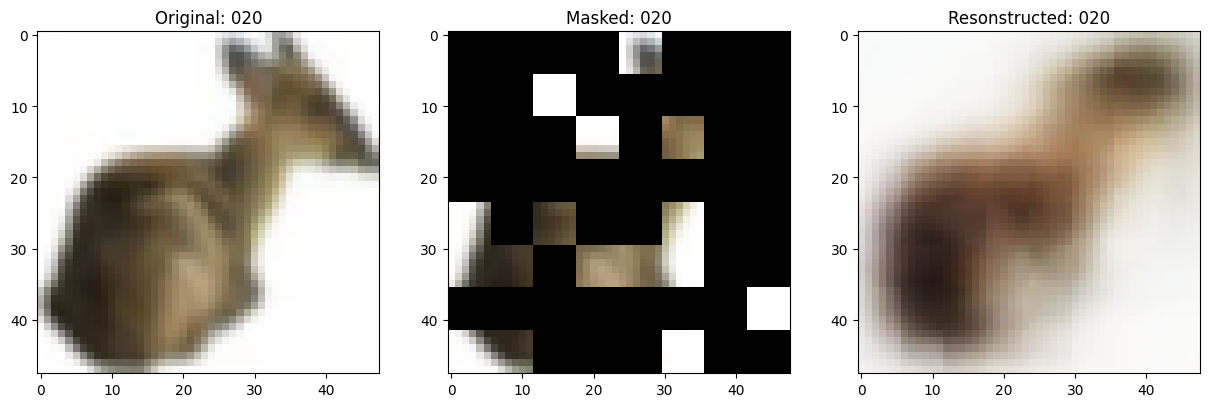

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - mae: 0.0988 - loss: 0.5568 - val_loss: 0.5640
Epoch 22/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - mae: 0.0967 - loss: 0.5574 - val_loss: 0.5625
Epoch 23/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - mae: 0.0965 - loss: 0.5579 - val_loss: 0.5634
Epoch 24/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - mae: 0.0962 - loss: 0.5583 - val_loss: 0.5615
Epoch 25/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - mae: 0.0977 - loss: 0.5584 - val_loss: 0.5607
Epoch 26/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - mae: 0.0960 - loss: 0.5576
Idx chosen: 20


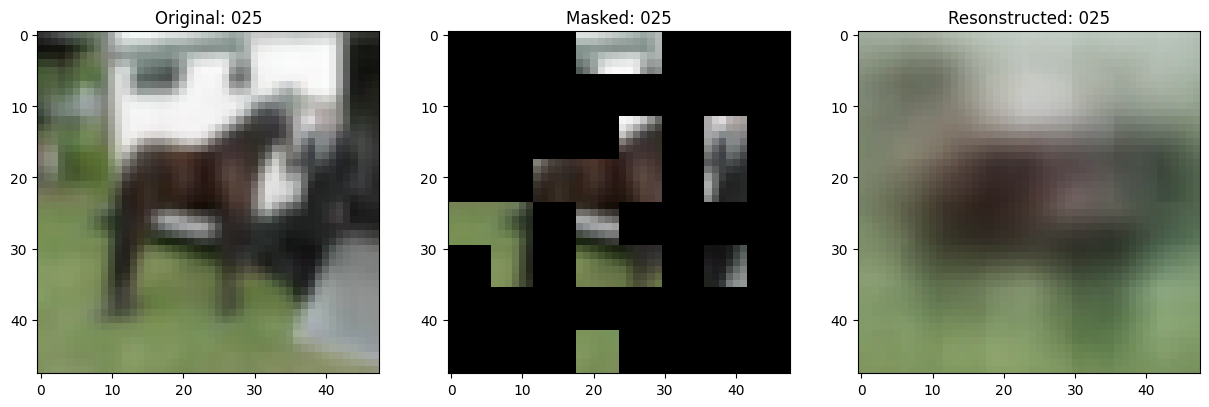

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - mae: 0.0960 - loss: 0.5579 - val_loss: 0.5605
Epoch 27/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - mae: 0.0972 - loss: 0.5584 - val_loss: 0.5598
Epoch 28/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - mae: 0.0964 - loss: 0.5586 - val_loss: 0.5637
Epoch 29/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - mae: 0.0953 - loss: 0.5588 - val_loss: 0.5622
Epoch 30/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - mae: 0.0947 - loss: 0.5586 - val_loss: 0.5615
Epoch 31/100
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - mae: 0.0946 - loss: 0.5590
Idx chosen: 102


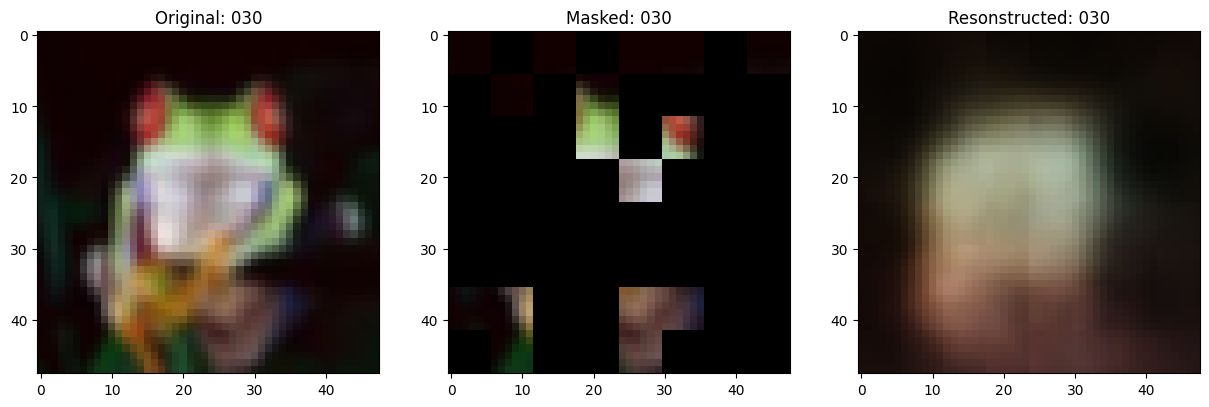

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - mae: 0.0953 - loss: 0.5587 - val_loss: 0.5656
Epoch 32/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - mae: 0.0934 - loss: 0.5591 - val_loss: 0.5653
Epoch 33/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - mae: 0.0931 - loss: 0.5594 - val_loss: 0.5660
Epoch 34/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - mae: 0.0950 - loss: 0.5595 - val_loss: 0.5658
Epoch 35/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - mae: 0.0935 - loss: 0.5594 - val_loss: 0.5648
Epoch 36/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - mae: 0.0931 - loss: 0.5605
Idx chosen: 121


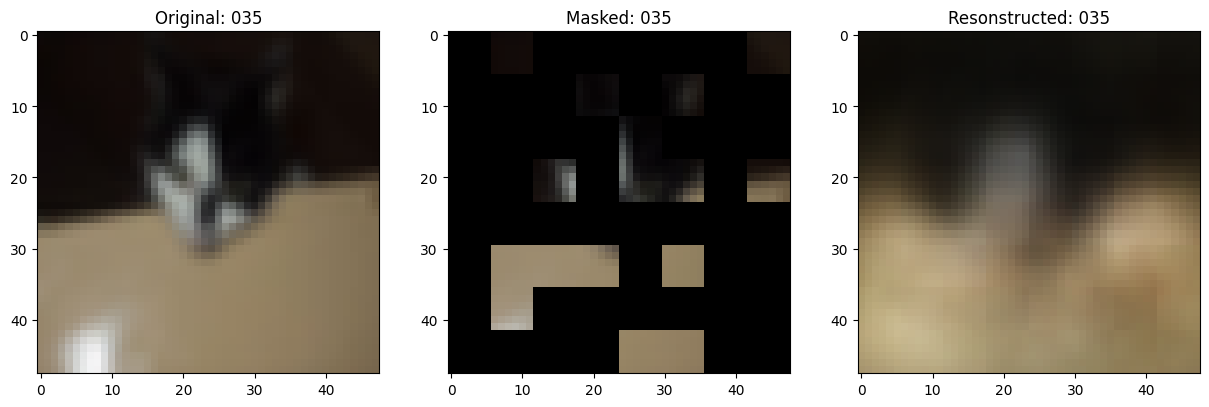

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - mae: 0.0921 - loss: 0.5600 - val_loss: 0.5675
Epoch 37/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - mae: 0.0931 - loss: 0.5600 - val_loss: 0.5658
Epoch 38/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - mae: 0.0932 - loss: 0.5600 - val_loss: 0.5660
Epoch 39/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - mae: 0.0932 - loss: 0.5597 - val_loss: 0.5651
Epoch 40/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - mae: 0.0922 - loss: 0.5605 - val_loss: 0.5669
Epoch 41/100
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - mae: 0.0923 - loss: 0.5611
Idx chosen: 210


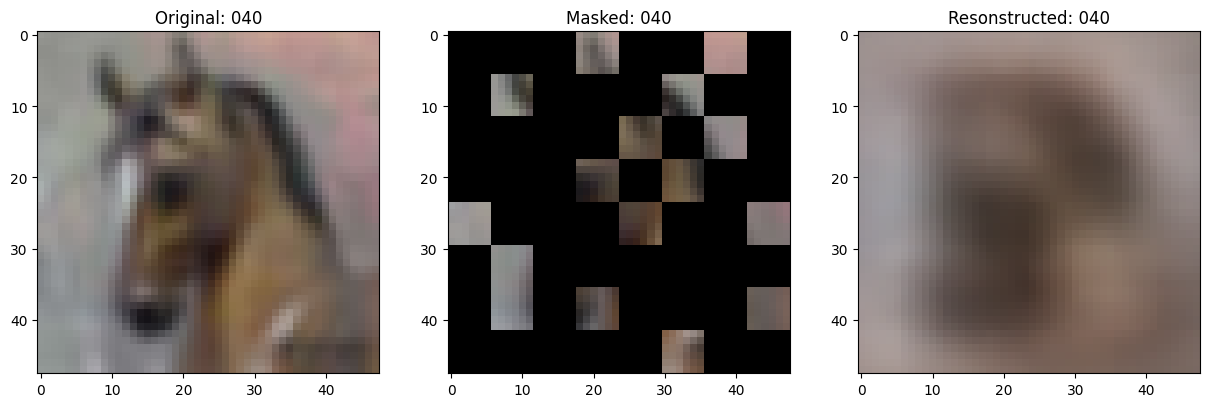

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - mae: 0.0922 - loss: 0.5605 - val_loss: 0.5661
Epoch 42/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - mae: 0.0924 - loss: 0.5595 - val_loss: 0.5662
Epoch 43/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - mae: 0.0920 - loss: 0.5605 - val_loss: 0.5691
Epoch 44/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - mae: 0.0914 - loss: 0.5606 - val_loss: 0.5651
Epoch 45/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - mae: 0.0901 - loss: 0.5604 - val_loss: 0.5693
Epoch 46/100
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - mae: 0.0913 - loss: 0.5608
Idx chosen: 214


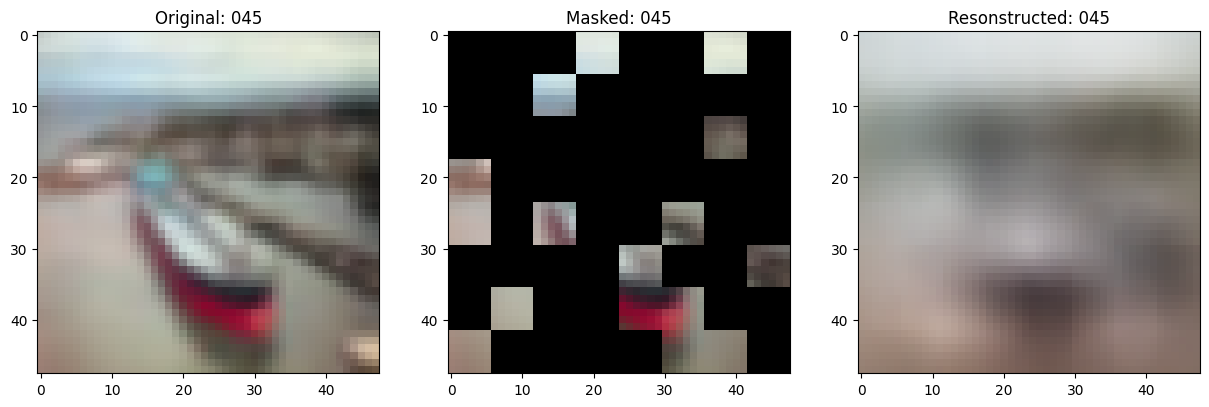

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - mae: 0.0926 - loss: 0.5606 - val_loss: 0.5682
Epoch 47/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - mae: 0.0911 - loss: 0.5610 - val_loss: 0.5692
Epoch 48/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - mae: 0.0912 - loss: 0.5603 - val_loss: 0.5650
Epoch 49/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - mae: 0.0917 - loss: 0.5606 - val_loss: 0.5688
Epoch 50/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - mae: 0.0907 - loss: 0.5612 - val_loss: 0.5666
Epoch 51/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - mae: 0.0905 - loss: 0.5613
Idx chosen: 74


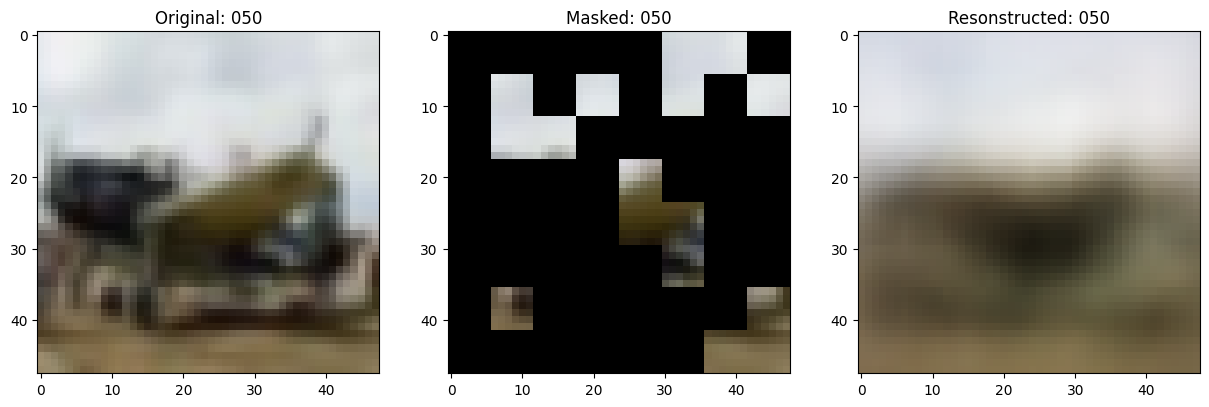

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - mae: 0.0900 - loss: 0.5611 - val_loss: 0.5696
Epoch 52/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - mae: 0.0894 - loss: 0.5613 - val_loss: 0.5676
Epoch 53/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - mae: 0.0902 - loss: 0.5614 - val_loss: 0.5659
Epoch 54/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - mae: 0.0896 - loss: 0.5616 - val_loss: 0.5676
Epoch 55/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - mae: 0.0891 - loss: 0.5617 - val_loss: 0.5691
Epoch 56/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - mae: 0.0898 - loss: 0.5626
Idx chosen: 202


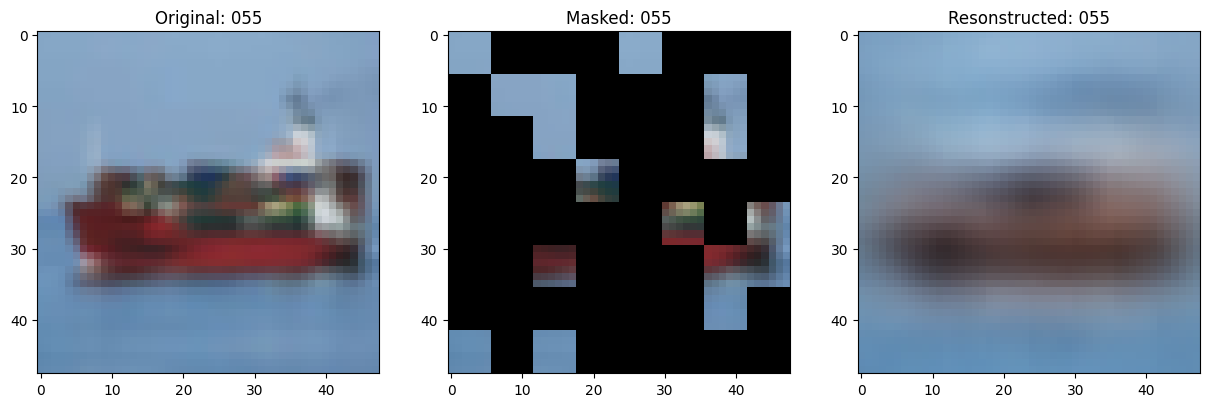

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - mae: 0.0901 - loss: 0.5618 - val_loss: 0.5654
Epoch 57/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - mae: 0.0886 - loss: 0.5615 - val_loss: 0.5685
Epoch 58/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - mae: 0.0908 - loss: 0.5622 - val_loss: 0.5641
Epoch 59/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - mae: 0.0890 - loss: 0.5618 - val_loss: 0.5661
Epoch 60/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - mae: 0.0894 - loss: 0.5622 - val_loss: 0.5645
Epoch 61/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - mae: 0.0889 - loss: 0.5628
Idx chosen: 87


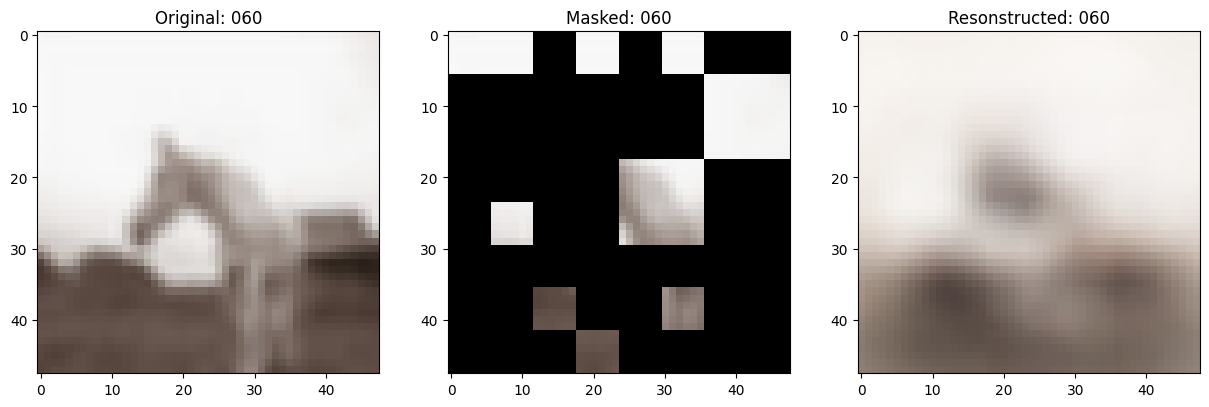

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - mae: 0.0894 - loss: 0.5623 - val_loss: 0.5666
Epoch 62/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - mae: 0.0901 - loss: 0.5618 - val_loss: 0.5700
Epoch 63/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - mae: 0.0886 - loss: 0.5617 - val_loss: 0.5693
Epoch 64/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - mae: 0.0882 - loss: 0.5624 - val_loss: 0.5691
Epoch 65/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - mae: 0.0888 - loss: 0.5623 - val_loss: 0.5652
Epoch 66/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - mae: 0.0884 - loss: 0.5621
Idx chosen: 116


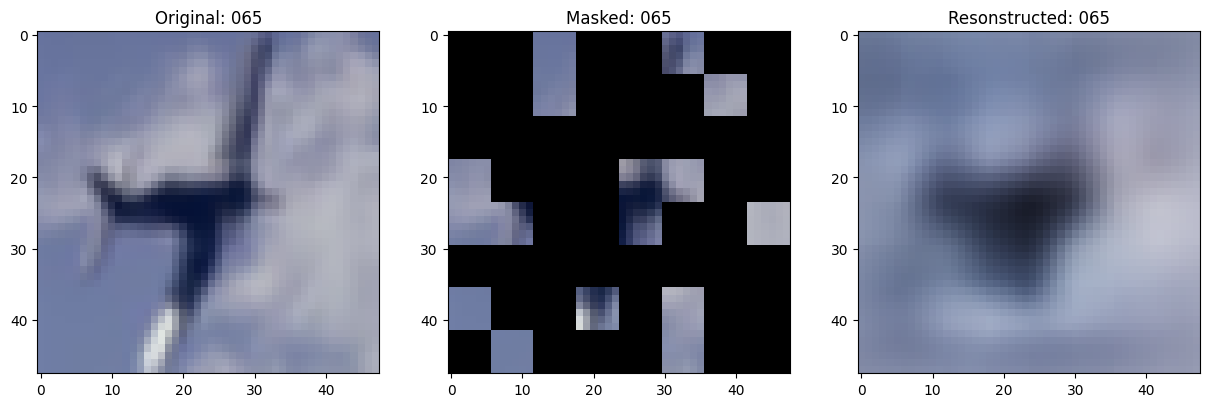

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - mae: 0.0876 - loss: 0.5622 - val_loss: 0.5682
Epoch 67/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - mae: 0.0875 - loss: 0.5627 - val_loss: 0.5686
Epoch 68/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - mae: 0.0872 - loss: 0.5628 - val_loss: 0.5703
Epoch 69/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - mae: 0.0877 - loss: 0.5632 - val_loss: 0.5679
Epoch 70/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - mae: 0.0874 - loss: 0.5622 - val_loss: 0.5682
Epoch 71/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - mae: 0.0876 - loss: 0.5636
Idx chosen: 99


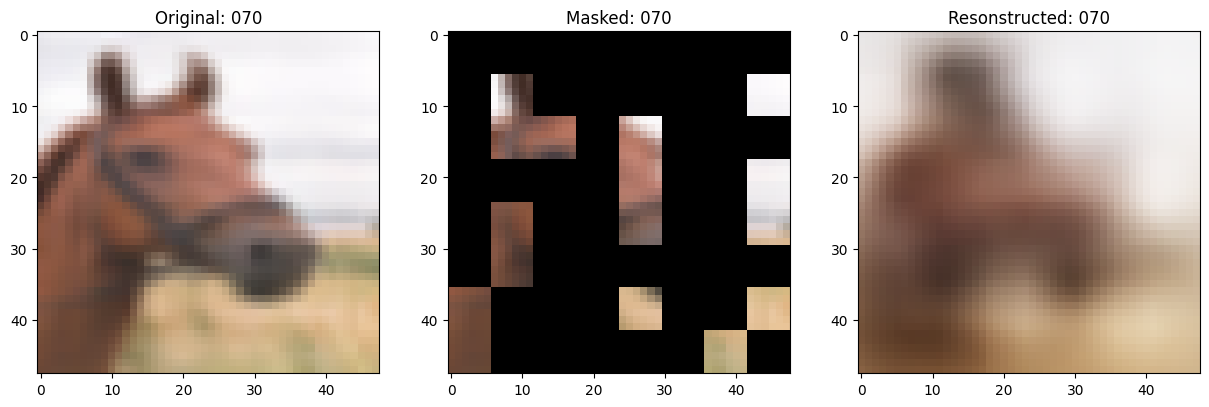

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - mae: 0.0874 - loss: 0.5629 - val_loss: 0.5694
Epoch 72/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - mae: 0.0879 - loss: 0.5629 - val_loss: 0.5694
Epoch 73/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - mae: 0.0870 - loss: 0.5627 - val_loss: 0.5683
Epoch 74/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - mae: 0.0869 - loss: 0.5631 - val_loss: 0.5673
Epoch 75/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - mae: 0.0867 - loss: 0.5630 - val_loss: 0.5685
Epoch 76/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - mae: 0.0868 - loss: 0.5640
Idx chosen: 103


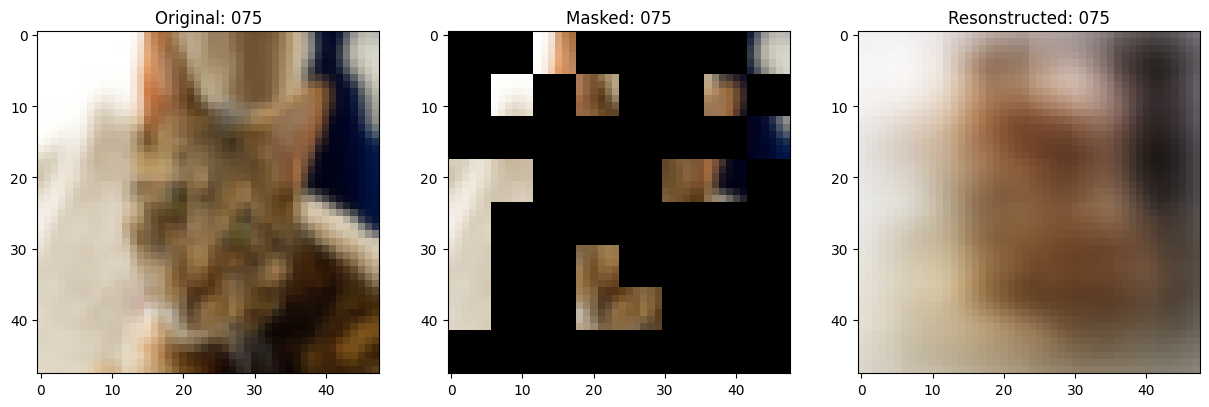

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - mae: 0.0864 - loss: 0.5636 - val_loss: 0.5686
Epoch 77/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - mae: 0.0863 - loss: 0.5630 - val_loss: 0.5695
Epoch 78/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - mae: 0.0864 - loss: 0.5631 - val_loss: 0.5680
Epoch 79/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - mae: 0.0865 - loss: 0.5635 - val_loss: 0.5689
Epoch 80/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - mae: 0.0861 - loss: 0.5634 - val_loss: 0.5692
Epoch 81/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - mae: 0.0863 - loss: 0.5637
Idx chosen: 151


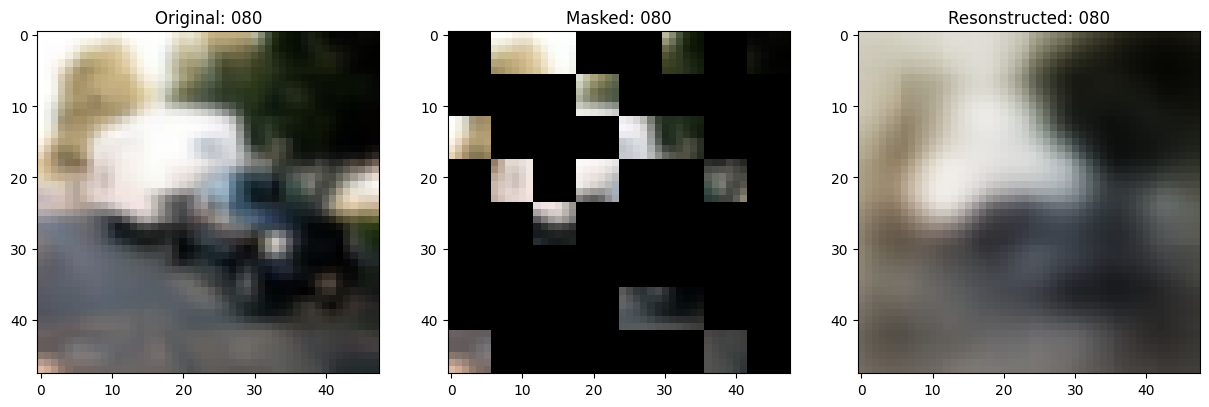

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - mae: 0.0857 - loss: 0.5632 - val_loss: 0.5695
Epoch 82/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - mae: 0.0865 - loss: 0.5636 - val_loss: 0.5688
Epoch 83/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - mae: 0.0856 - loss: 0.5638 - val_loss: 0.5704
Epoch 84/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - mae: 0.0857 - loss: 0.5637 - val_loss: 0.5687
Epoch 85/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - mae: 0.0857 - loss: 0.5638 - val_loss: 0.5697
Epoch 86/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - mae: 0.0858 - loss: 0.5643
Idx chosen: 130


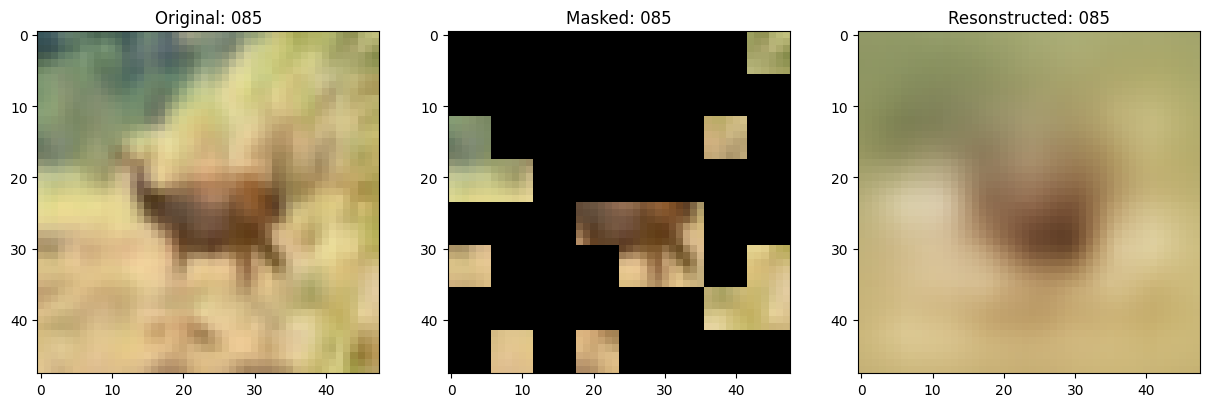

157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - mae: 0.0858 - loss: 0.5636 - val_loss: 0.5685
Epoch 87/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - mae: 0.0852 - loss: 0.5638 - val_loss: 0.5700
Epoch 88/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - mae: 0.0853 - loss: 0.5635 - val_loss: 0.5694
Epoch 89/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - mae: 0.0855 - loss: 0.5638 - val_loss: 0.5697
Epoch 90/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - mae: 0.0853 - loss: 0.5639 - val_loss: 0.5692
Epoch 91/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - mae: 0.0855 - loss: 0.5643
Idx chosen: 149


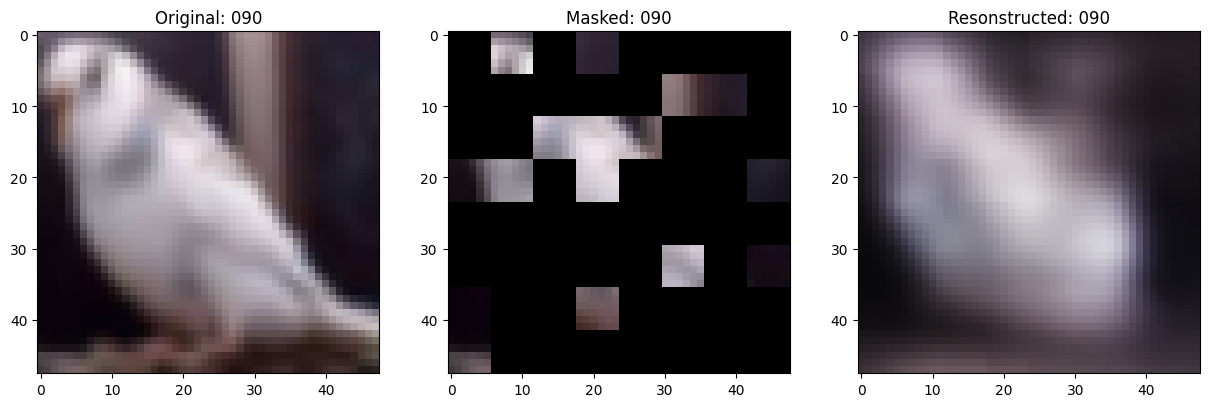

157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - mae: 0.0853 - loss: 0.5638 - val_loss: 0.5696
Epoch 92/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - mae: 0.0853 - loss: 0.5642 - val_loss: 0.5693
Epoch 93/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - mae: 0.0850 - loss: 0.5639 - val_loss: 0.5695
Epoch 94/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - mae: 0.0850 - loss: 0.5643 - val_loss: 0.5695
Epoch 95/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - mae: 0.0851 - loss: 0.5636 - val_loss: 0.5694
Epoch 96/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - mae: 0.0853 - loss: 0.5642
Idx chosen: 52


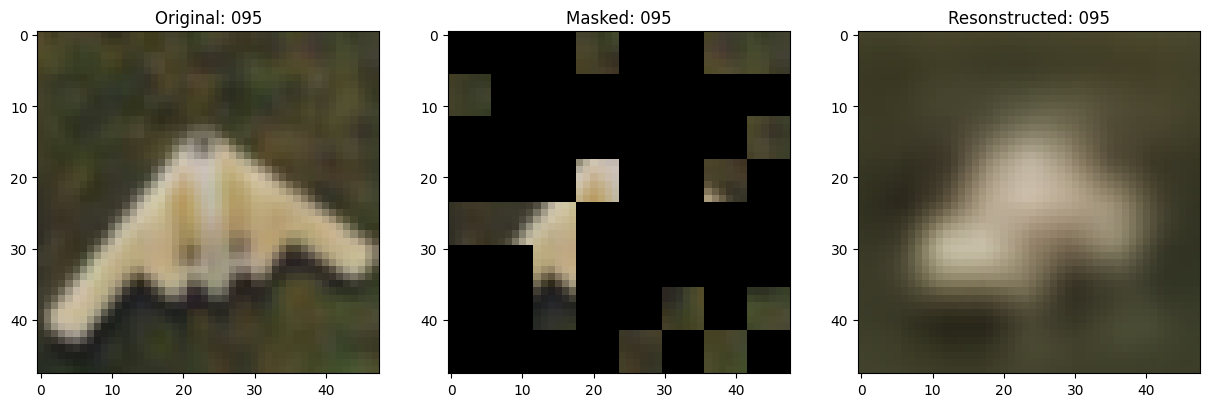

157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - mae: 0.0851 - loss: 0.5637 - val_loss: 0.5697
Epoch 97/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - mae: 0.0850 - loss: 0.5638 - val_loss: 0.5696
Epoch 98/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - mae: 0.0850 - loss: 0.5636 - val_loss: 0.5694
Epoch 99/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - mae: 0.0851 - loss: 0.5637 - val_loss: 0.5697
Epoch 100/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - mae: 0.0852 - loss: 0.5641 - val_loss: 0.5695
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - mae: 0.0853 - loss: 0.5720
Loss: 0.57


TypeError: unsupported format string passed to dict.__format__

In [16]:
optimizer = keras.optimizers.AdamW(
    learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY
)

# Compile and pretrain the model.
mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)
history = mae_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=train_callbacks,
)

# Measure its performance.
loss, mae = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

In [17]:
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing).
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="linear_probe_model",
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()

Model: "linear_probe_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patches_1 (Patches)             │ (None, 64, 108)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder_1 (PatchEncoder)  │ (None, 64, 128)        │        22,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mae_encoder (Functional)        │ (None, 64, 128)        │     1,981,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,005,642 (7.65 MB)

 Trainable params: 1,290 (5.04 KB)

 Non-trainable params: 2,004,352 (7.65 MB)

In [18]:
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)


train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_train, y_train, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)

In [19]:
linear_probe_epochs = 50
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

Epoch 1/50


2025-11-02 09:43:02.948049: I external/local_xla/xla/service/service.cc:163] XLA service 0x7aca92064160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-02 09:43:02.948122: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-11-02 09:43:03.141695: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-02 09:43:03.771399: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


 10/157 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0959 - loss: 2.8961

I0000 00:00:1762072988.112052   12290 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.2289 - loss: 2.2170 - val_accuracy: 0.3787 - val_loss: 1.7807
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.3701 - loss: 1.7653 - val_accuracy: 0.4175 - val_loss: 1.6574
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.3859 - loss: 1.7085 - val_accuracy: 0.4130 - val_loss: 1.6372
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3873 - loss: 1.6870 - val_accuracy: 0.4124 - val_loss: 1.6184
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.3845 - loss: 1.6840 - val_accuracy: 0.3959 - val_loss: 1.6342
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.3895 - loss: 1.6705 - val_accuracy: 0.4085 - val_loss: 1.6076
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.3931 - loss: 1.6684 - val_accuracy: 0.4309 - val_loss: 1.5543
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.3954 - loss: 1.6574 - val_accuracy: 0.44